# MIMIC-III Data Analysis: Predicting Length of Stay in ICU

**June 8, 2025**

This notebook presents a comprehensive data analysis and machine learning pipeline using the MIMIC-III (Medical Information Mart for Intensive Care III) database. The primary objective is to develop and evaluate a predictive model for Length of Stay (LOS) in the Intensive Care Unit (ICU) for patients diagnosed with a specific medical condition.

The project is structured into several distinct parts to ensure clarity and logical progression:

* **Part 1: Data Loading & Dictionaries**
* **Part 2: Disease Selection**
* **Part 3 & 4: Patient Cohort & ICU Stay Integration**
* **Part 5: Exploratory Data Analysis & Visualization**
* **Part 6 & 7: CHARTEVENTS Preprocessing**
* **Part 8 & 9: Event Aggregation & Feature Engineering**
* **Part 10 & 11: Final Data Preparation**
* **Part 12: Data Splitting & Scaling**
* **Part 13 & 14: Model Training & Optimization**
* **Part 15: Model Interpretation (SHAP)**
* **Conclusions**

Each section is designed to be self-contained and clearly documented to facilitate understanding of the complete analytical process.

# Environment Setup and Library Imports

This section is dedicated to setting up the Python environment and importing all necessary libraries required for data manipulation, visualization, machine learning model building, and interpretation throughout the notebook.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import shap
import os
import gc

# Part 1
Loading dictionaries for ICD9 and ITEMS

In [ ]:
pd.set_option('display.max_colwidth', None) # To view the full title of text columns

# --- PART 1: Load Dictionary Tables ---
print("--- Part 1: Load Dictionary Tables ---")
# D_ICD_DIAGNOSES.csv: Dictionary for ICD9_CODEs
df_d_icd_diagnoses = pd.read_csv(r"D_ICD_DIAGNOSES.csv")
print("df_d_icd_diagnoses loaded.")
df_d_icd_diagnoses.info()

# D_ITEMS.csv: Dictionary for ITEMID (CHARTEVENTS)
d_items = pd.read_csv(r"D_ITEMS.csv", usecols=['ITEMID', 'LABEL'])
id_to_label = dict(zip(d_items['ITEMID'], d_items['LABEL']))
print("\nD_ITEMS loaded.")


--- Part 1: Load Dictionary Tables ---
df_d_icd_diagnoses loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14567 entries, 0 to 14566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       14567 non-null  int64 
 1   ICD9_CODE    14567 non-null  object
 2   SHORT_TITLE  14567 non-null  object
 3   LONG_TITLE   14567 non-null  object
dtypes: int64(1), object(3)
memory usage: 455.3+ KB

D_ITEMS loaded.


# PART 2
Choice of the ICD9 disease

In [ ]:
# --- PART 2: Disease Selection (ICD9_CODE) ---
print("\n--- Part 2: Disease Selection (ICD9_CODE) ---")
# Define the ICD9_CODE for Atrial Fibrillation
chosen_icd9_code = "42731"
print(f"\nChosen ICD9_CODE for analysis: {chosen_icd9_code}")

# Get the long title of the disease
icd9_title = df_d_icd_diagnoses[df_d_icd_diagnoses["ICD9_CODE"] == chosen_icd9_code]["LONG_TITLE"].iloc[0]
print(f"Disease title: {icd9_title}")


--- Part 2: Disease Selection (ICD9_CODE) ---

Chosen ICD9_CODE for analysis: 42731
Disease title: Atrial fibrillation


# PART 3
Filtering by relevant to our disease

In [ ]:
# --- PART 3: Get Patients with the Chosen Diagnosis (DIAGNOSES_ICD.csv) ---
print("\n--- Part 3: Get Patients with the Chosen Diagnosis ---")
# Load DIAGNOSES_ICD.csv (or .gz if preferred)
print("Loading DIAGNOSES_ICD.csv to filter patients with the chosen diagnosis...")
df_diag = pd.read_csv(
    r"DIAGNOSES_ICD.csv", # <--- Using .csv (without .gz)
    usecols=['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE'],
    low_memory=False
)
print("DIAGNOSES_ICD.csv loaded.")
df_diag.info()

# Filter for the chosen ICD9_CODE
df_dia = df_diag[df_diag["ICD9_CODE"] == chosen_icd9_code].copy()
print(f"\nNumber of occurrences of ICD9_CODE {chosen_icd9_code} in DIAGNOSES_ICD: {len(df_dia)}")
print(f"Number of unique patients with {chosen_icd9_code}: {df_dia['SUBJECT_ID'].nunique()}")
df_dia.head()


--- Part 3: Get Patients with the Chosen Diagnosis ---
Loading DIAGNOSES_ICD.csv to filter patients with the chosen diagnosis...
DIAGNOSES_ICD.csv loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   SUBJECT_ID  651047 non-null  int64 
 1   HADM_ID     651047 non-null  int64 
 2   ICD9_CODE   651000 non-null  object
dtypes: int64(2), object(1)
memory usage: 14.9+ MB

Number of occurrences of ICD9_CODE 42731 in DIAGNOSES_ICD: 12891
Number of unique patients with 42731: 10271


,SUBJECT_ID,HADM_ID,ICD9_CODE
134,124,134369,42731
152,124,138376,42731
169,125,157348,42731
204,130,113323,42731
265,137,151583,42731


# PART 4
Connecting Diagnoses with ICU stays and merging to allow for inspection of LOS and INTIME for patients

In [ ]:
# --- PART 4: Connect Diagnoses with ICU Stays (ICUSTAYS.csv) ---
print("\n--- Part 4: Connect Diagnoses with ICU Stays ---")
df_icu = pd.read_csv(r"ICUSTAYS.csv")
print("ICUSTAYS.csv loaded.")
df_icu.info()

# Merge to get LOS and INTIME for patients with the disease
df_dia_icu = pd.merge(df_dia, df_icu, on=["SUBJECT_ID", "HADM_ID"], how='inner')
print(f"\nDataFrame df_dia_icu created (Merge of DIAGNOSES_ICD and ICUSTAYS).")
print(f"ICU stays for ICD9_CODE {chosen_icd9_code}: {len(df_dia_icu)}")
print(f"Unique patients (df_dia_icu): {df_dia_icu['SUBJECT_ID'].nunique()}")
print(f"Unique ICU stays (df_dia_icu): {df_dia_icu['ICUSTAY_ID'].nunique()}")
df_dia_icu.head()

# *** CRITICAL variable icu_ids_for_chosen_icd for CHARTEVENTS filtering ***
icu_ids_for_chosen_icd = df_dia_icu["ICUSTAY_ID"].unique()
print(f"\nVariable 'icu_ids_for_chosen_icd' defined with {len(icu_ids_for_chosen_icd)} unique IDs.")



--- Part 4: Connect Diagnoses with ICU Stays ---


ICUSTAYS.csv loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB

DataFrame df_dia_icu created (Merge of DIAGNOSES_ICD and ICUSTAYS).
ICU stays for ICD9_CODE 42731: 14048
Unique patients (df_dia_icu): 10252
Unique ICU stays (df_dia_icu): 14043

# PART 5

This section defines a function to analyze and plot medication administration trends for a specific patient (`SUBJECT_ID`). It uses ICU stay info, medication input events, and item metadata to produce:

- A normalized daily medication dose trend over the ICU stay
- A detailed scatter and trend plot of medication doses in the first 24 hours by hour

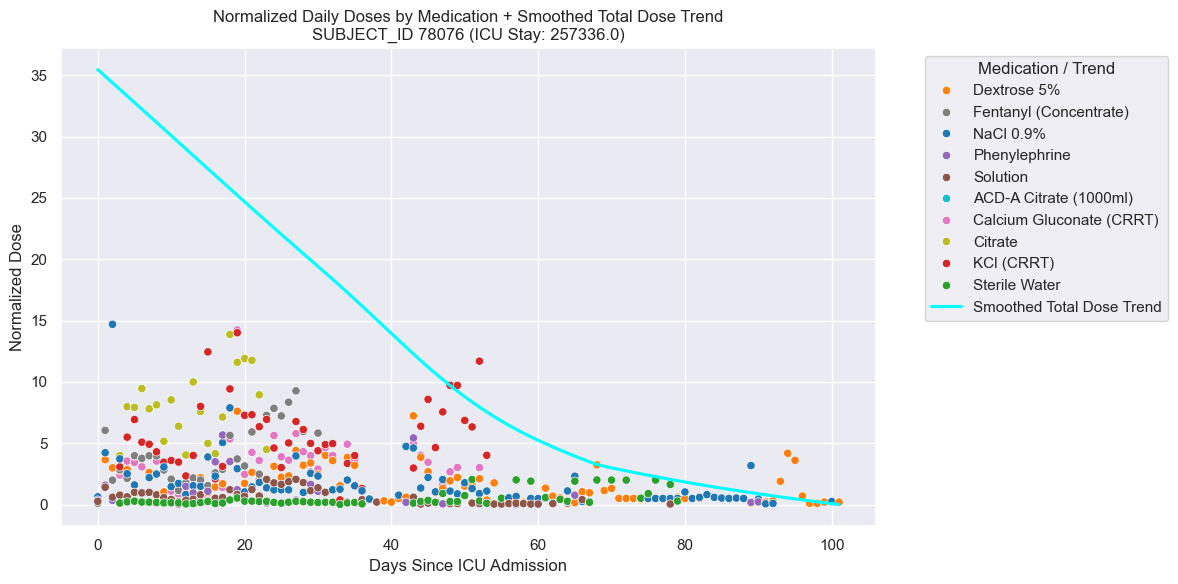

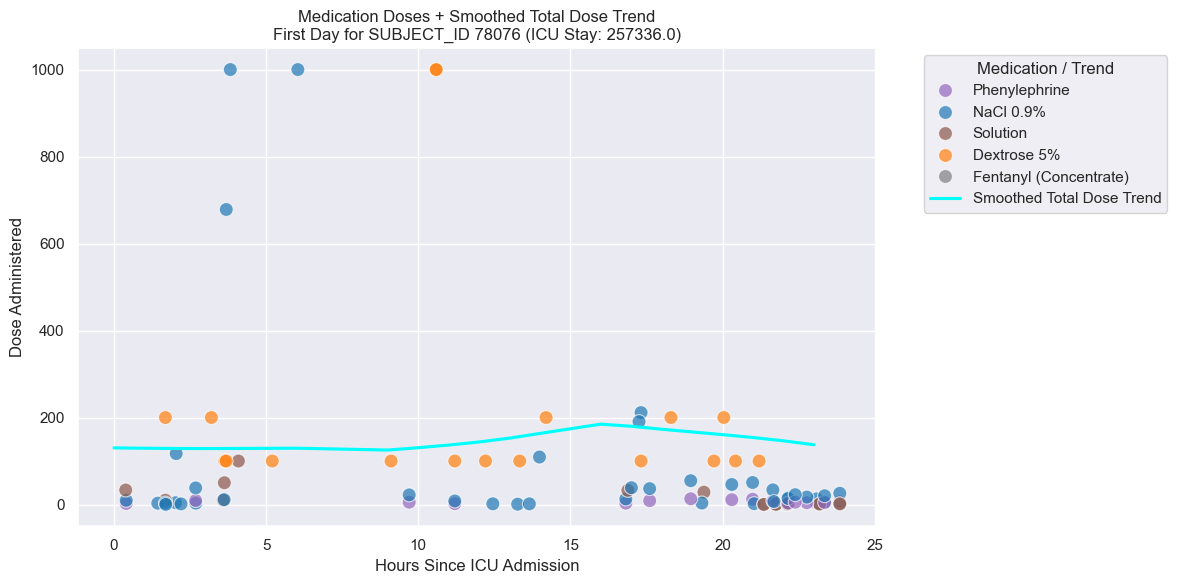

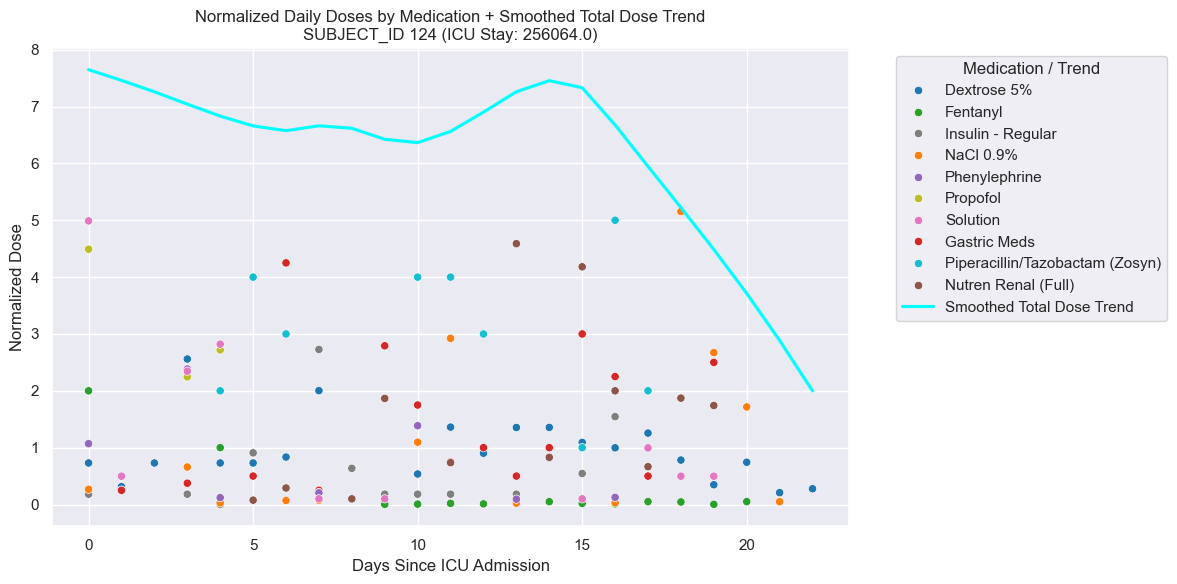

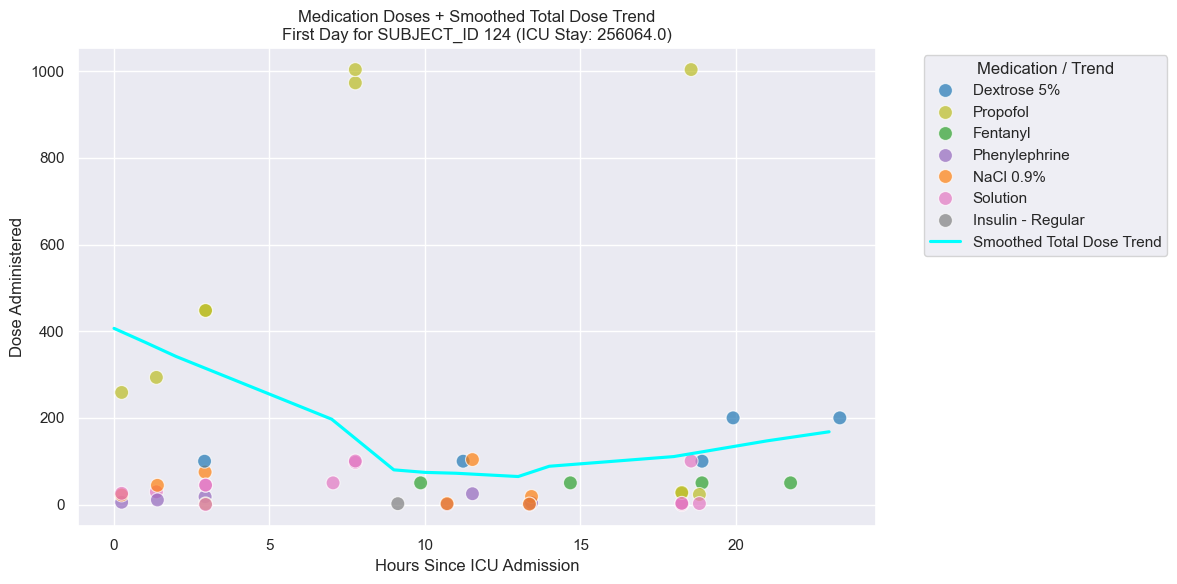

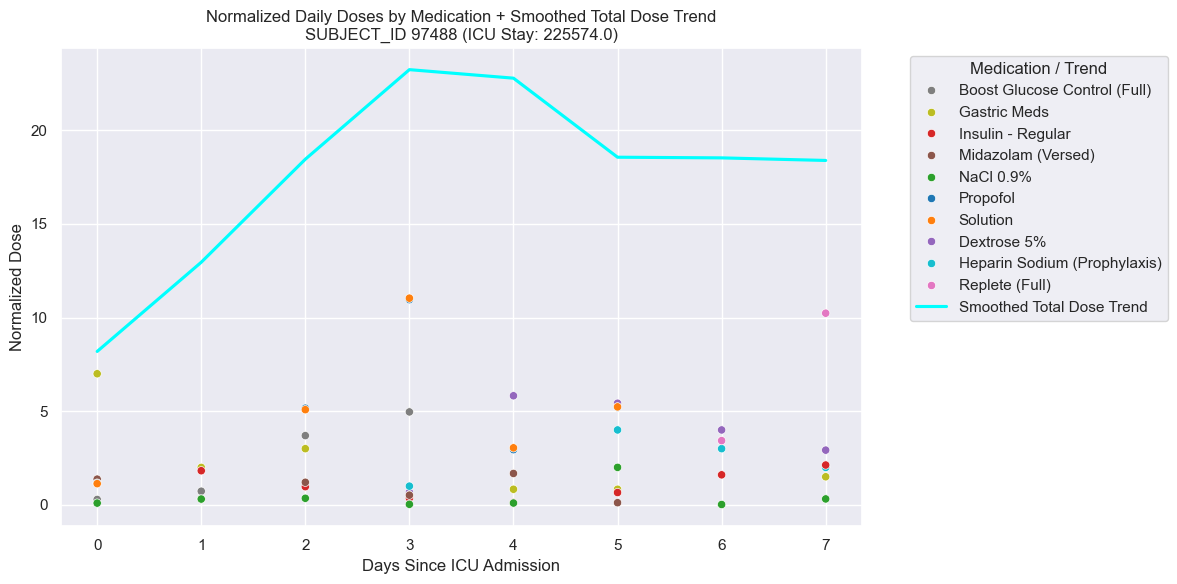

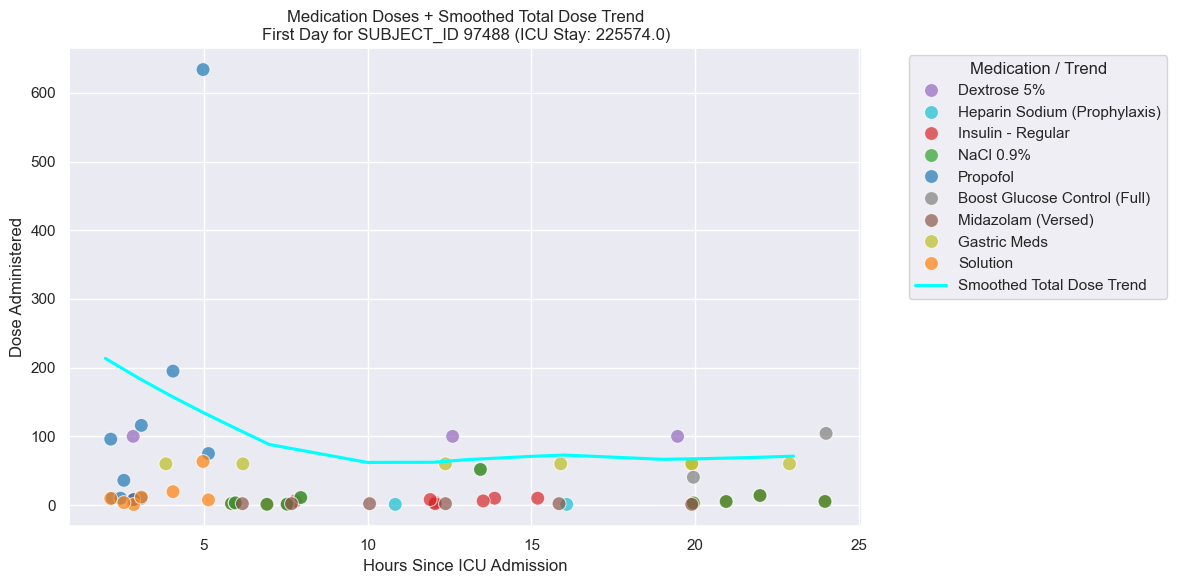

In [ ]:
# --- PART 5: Statistical analysis and visualization of data for each patient (SUBJECT_ID) ---
df_input = pd.read_csv("INPUTEVENTS_MV.csv", low_memory=False)
df_items = pd.read_csv("D_ITEMS.csv")
sns.set_theme(style="darkgrid")

def plot_patient_medication_trends(subject_id, top_n=10):
    """
    Processes and visualizes medication administration data for a specific patient.

    Args:
        subject_id (int): The subject ID of the patient.
        df_icu (pd.DataFrame): DataFrame with ICU stay information.
        df_input (pd.DataFrame): DataFrame with input events data.
        df_items (pd.DataFrame): DataFrame with item definitions.
        top_n (int): The number of top medications to display. Defaults to 10.
    """
    # --- Select patient ---
    # subject_id is now a function argument

    # --- Get ICU stays for this patient ---
    patient_icus = df_icu[df_icu["SUBJECT_ID"] == subject_id][["ICUSTAY_ID", "INTIME"]].copy()
    patient_icus["INTIME"] = pd.to_datetime(patient_icus["INTIME"])

    # --- Filter input events for patient's ICU stays ---
    df_example = df_input[df_input["ICUSTAY_ID"].isin(patient_icus["ICUSTAY_ID"])].copy()

    # --- Merge INTIME for time calculations ---
    df_example = df_example.merge(patient_icus, on="ICUSTAY_ID", how="left")
    df_example["STARTTIME"] = pd.to_datetime(df_example["STARTTIME"])

    # --- Calculate hours and days since ICU admission ---
    df_example["HOURS_SINCE_INTIME"] = (df_example["STARTTIME"] - df_example["INTIME"]).dt.total_seconds() / 3600
    df_example["DAY"] = (df_example["HOURS_SINCE_INTIME"] // 24).astype(int)  # integer day bins

    # --- Merge item labels ---
    df_example = df_example.merge(df_items[["ITEMID", "LABEL"]], on="ITEMID", how="left")

    # --- Filter out rows with missing amounts or labels ---
    df_example = df_example.dropna(subset=["AMOUNT", "LABEL"])

    # --- Filter to top N medications by count to reduce clutter ---
    top_items = df_example["LABEL"].value_counts().nlargest(top_n).index
    df_example_top = df_example[df_example["LABEL"].isin(top_items)].copy()

    # --- NEW LINES START ---
    # This is the only code added. It creates a consistent color map.
    palette_colors = sns.color_palette('tab10', n_colors=top_n)
    palette_map = dict(zip(top_items, palette_colors))
    # --- NEW LINES END ---

    # --- Normalize doses per medication by max dose across all ICU stays ---
    max_dose_per_med = df_example_top.groupby("LABEL")["AMOUNT"].max()
    df_example_top["AMOUNT_NORM"] = df_example_top.apply(
        lambda row: row["AMOUNT"] / max_dose_per_med.loc[row["LABEL"]], axis=1
    )

    # --- Find ICU stay with highest number of events ---
    icu_counts = df_example_top["ICUSTAY_ID"].value_counts()
    if icu_counts.empty:
        print(f"No medication data found for SUBJECT_ID {subject_id} after filtering.")
        return
    top_icu = icu_counts.idxmax()

    # --- Filter data for that ICU stay only ---
    df_top_icu = df_example_top[df_example_top["ICUSTAY_ID"] == top_icu].copy()

    # Aggregate daily total normalized doses per medication for the selected ICU stay
    daily_doses = df_top_icu.groupby(["DAY", "LABEL"])["AMOUNT_NORM"].sum().reset_index()

    # Sum total normalized dose across all meds for each day
    daily_total = daily_doses.groupby("DAY")["AMOUNT_NORM"].sum().reset_index(name="TOTAL_DOSE_NORM")
    daily_total = daily_total.sort_values("DAY")

    plt.figure(figsize=(12, 6))

    # Scatter plot of normalized dose per med per day (each med a different color)
    sns.scatterplot(data=daily_doses, x="DAY", y="AMOUNT_NORM", hue="LABEL", marker="o", palette=palette_map)

    # Smoothed trend line for total dose per day using LOWESS
    sns.regplot(
        data=daily_total,
        x="DAY",
        y="TOTAL_DOSE_NORM",
        lowess=True,
        scatter=False,
        color="cyan",
        label="Smoothed Total Dose Trend"
    )

    plt.title(f"Normalized Daily Doses by Medication + Smoothed Total Dose Trend\nSUBJECT_ID {subject_id} (ICU Stay: {top_icu})")
    plt.xlabel("Days Since ICU Admission")
    plt.ylabel("Normalized Dose")
    plt.legend(title="Medication / Trend", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # --- Now plot doses for first day by hour ---

    df_first_day = df_example_top[(df_example_top["HOURS_SINCE_INTIME"] >= 0) & (df_example_top["HOURS_SINCE_INTIME"] < 24)].copy()
    df_first_day['HOUR_INT'] = df_first_day['HOURS_SINCE_INTIME'].astype(int)

    plt.figure(figsize=(12, 6))

    # Scatter of individual doses by hour
    sns.scatterplot(
        data=df_first_day,
        x="HOURS_SINCE_INTIME",
        y="AMOUNT",
        hue="LABEL",
        palette=palette_map,
        s=100,
        alpha=0.7,
        legend='full'
    )

    # Aggregate total dose per hour
    hourly_sum = df_first_day.groupby('HOUR_INT')['AMOUNT'].sum().reset_index()

    # Smoothed trend line on total doses per hour using LOWESS
    sns.regplot(
        data=hourly_sum,
        x="HOUR_INT",
        y="AMOUNT",
        lowess=True,
        scatter=False,
        color='cyan',
        label='Smoothed Total Dose Trend'
    )

    plt.title(f"Medication Doses + Smoothed Total Dose Trend\nFirst Day for SUBJECT_ID {subject_id} (ICU Stay: {top_icu})")
    plt.xlabel("Hours Since ICU Admission")
    plt.ylabel("Dose Administered")
    plt.legend(title="Medication / Trend", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_patient_medication_trends(subject_id=78076, top_n=10)
plot_patient_medication_trends(subject_id=124, top_n=10)
plot_patient_medication_trends(subject_id=97488, top_n=10)

We can see there are some tendencies like the medical doses are higher at the start and tend to decrease over the stay ( all are normalized in order to be able to acess in the multy day graph), regarding the frist day of stay there arent clear tendencies but it does seem like there are point of higher doses during the day.

We will now do a length of stay analysis:

This section provides an exploratory analysis of the Length of Stay (LOS) variable. It begins with a summary of basic statistics, offering insights into the central tendency and spread of LOS across all admissions. To visually assess its distribution, the code plots both a histogram and a boxplot, helping to highlight skewness and potential outliers.

It then computes key percentiles (25th, 50th, 75th, 90th, and 95th) to better understand how LOS is distributed across the patient population. Following that, the analysis shifts focus from admissions to individual patients by aggregating LOS values per SUBJECT_ID. For each patient, the average LOS, total LOS, and the number of admissions are computed.

To further segment the population, patients are divided into deciles based on their total LOS. These deciles are merged back into the main dataset, allowing for group-based analysis. A boxplot then visualizes how LOS varies across these deciles, revealing how patients with higher overall LOS tend to experience longer individual stays. Lastly, a histogram of the average LOS per patient is shown, offering another view of variability across the patient cohort.



--- Part 5: Length of Stay (LOS) Analysis ---

Basic LOS statistics:
count    14046.000000
mean         4.979636
std          6.881216
min          0.000100
25%          1.402400
50%          2.746050
75%          5.264275
max        116.832700
Name: LOS, dtype: float64


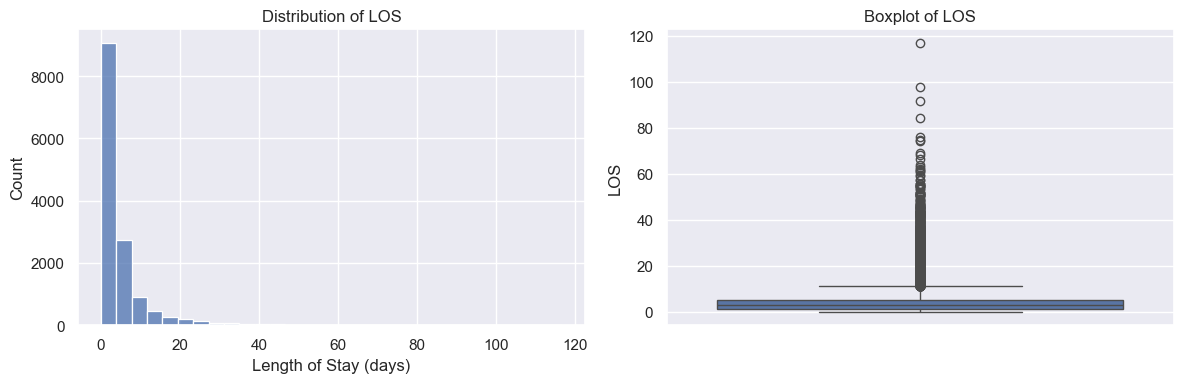


Important LOS percentiles:
25th percentile: 1.40
50th percentile: 2.75
75th percentile: 5.26
90th percentile: 11.24
95th percentile: 17.99


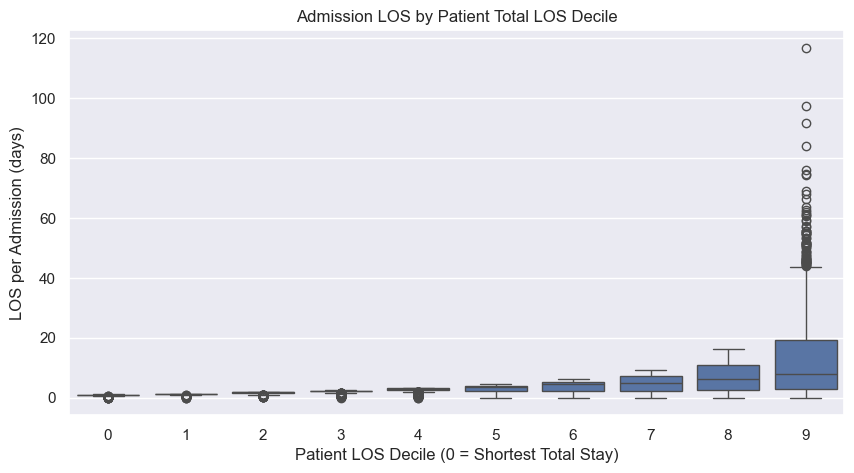

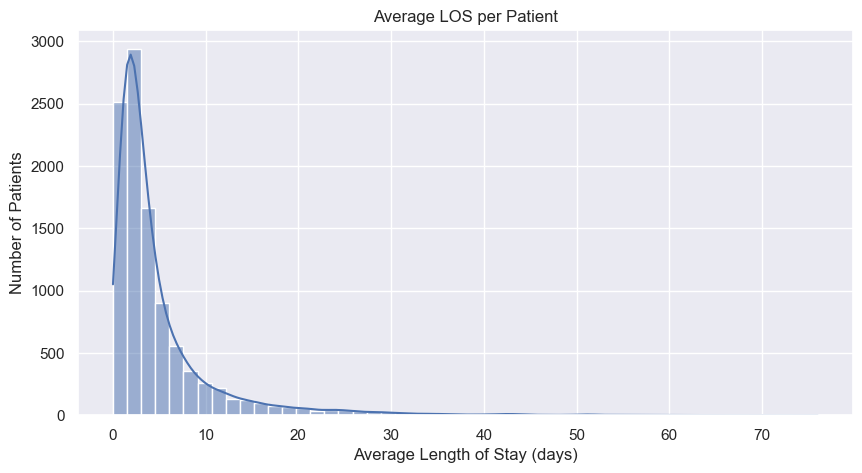

In [ ]:
# --- PART 5.2: Length of Stay (LOS) Analysis ---
print("\n--- Part 5: Length of Stay (LOS) Analysis ---")

# Basic stats
print("\nBasic LOS statistics:")
print(df_dia_icu['LOS'].describe())

# Plot distribution and boxplot of LOS
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=df_dia_icu, x='LOS', bins=30)
plt.title('Distribution of LOS')
plt.xlabel('Length of Stay (days)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_dia_icu, y='LOS')
plt.title('Boxplot of LOS')
plt.tight_layout()
plt.show()

# Print important percentiles
print("\nImportant LOS percentiles:")
percentiles = [25, 50, 75, 90, 95]
for p in percentiles:
    print(f"{p}th percentile: {df_dia_icu['LOS'].quantile(p/100):.2f}")

# --- Additional Analysis: LOS by patient (SUBJECT_ID) ---
# Aggregate LOS per patient
patient_los_stats = df_dia_icu.groupby("SUBJECT_ID")["LOS"].agg(["mean", "sum", "count"]).reset_index()
patient_los_stats.columns = ["SUBJECT_ID", "AVG_LOS", "TOTAL_LOS", "ADMISSION_COUNT"]

# Create deciles based on total LOS
patient_los_stats["LOS_DECILE"] = pd.qcut(patient_los_stats["TOTAL_LOS"], q=10, labels=False)

# Merge back into original df for plotting
df_dia_icu = df_dia_icu.merge(patient_los_stats[["SUBJECT_ID", "LOS_DECILE"]], on="SUBJECT_ID", how="left")

# Boxplot: LOS per admission grouped by patient LOS decile
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_dia_icu, x="LOS_DECILE", y="LOS")
plt.title("Admission LOS by Patient Total LOS Decile")
plt.xlabel("Patient LOS Decile (0 = Shortest Total Stay)")
plt.ylabel("LOS per Admission (days)")
plt.show()

# Histogram: Average LOS per patient
plt.figure(figsize=(10, 5))
sns.histplot(patient_los_stats["AVG_LOS"], bins=50, kde=True)
plt.title("Average LOS per Patient")
plt.xlabel("Average Length of Stay (days)")
plt.ylabel("Number of Patients")
plt.show()




The average length of stay is relatively low, indicating that most patients tend to have short hospitalizations. However, the presence of significant outliers with much higher LOS values introduces a heavy tail in the distribution. This imbalance makes it likely that the model will overfit to the more common short-stay cases, leading to poor generalization and underperformance when predicting longer, less frequent stays.

# PART 6
To efficiently manage the large size of the CHARTEVENTS.csv file, we implemented chunked reading and filtering. Instead of loading the entire dataset into memory — which could be tens of millions of rows and lead to crashes or performance issues — we processed it in manageable chunks of 1 million rows. This allowed us to filter only the relevant ICU stays (ICUSTAY_IDs) associated with our target diagnosis code (icu_ids_for_chosen_icd), drastically reducing the memory footprint and processing time.

In [ ]:
# --- PART 6: Load and Filter CHARTEVENTS.csv with chunks and save for future use ---
print("\n--- Part 6: Load and Filter CHARTEVENTS.csv with chunks ---")

path_chartevents_full = r"CHARTEVENTS.csv"
path_filtered_csv = "filtered_chartevents.csv"  # Path where we will save the result
cols_chart_needed = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM', 'VALUEUOM']
chunk_size = 10**6  # 1 million rows per chunk

# Checks if the filtered file already exists
if os.path.exists(path_filtered_csv):
    print(f" '{path_filtered_csv}' already exists, loading directly without re-filtering...")
    df_chart_dia = pd.read_csv(path_filtered_csv)
else:
    print(f" Processing CHARTEVENTS.csv with chunks (this will only take time this once)...")
    filtered_chunks = []

    try:
        for chunk in pd.read_csv(path_chartevents_full, usecols=cols_chart_needed,
                                 chunksize=chunk_size, low_memory=False, on_bad_lines='skip'):
            filtered = chunk[chunk["ICUSTAY_ID"].isin(icu_ids_for_chosen_icd)]
            if not filtered.empty:
                filtered_chunks.append(filtered)

        df_chart_dia = pd.concat(filtered_chunks, ignore_index=True)
        print(f" Filtering completed. Relevant events: {len(df_chart_dia)}")

    except Exception as e:
        print(f" Error processing CHARTEVENTS.csv with chunks: {e}")



--- Part 6: Load and Filter CHARTEVENTS.csv with chunks ---
 Processing CHARTEVENTS.csv with chunks (this will only take time this once)...
 Filtering completed. Relevant events: 13410897


In [ ]:
# Display information about the loaded/filtered df_chart_dia
print("\nInformation about df_chart_dia (filtered for the disease):")
df_chart_dia.info()
df_chart_dia.head()


Information about df_chart_dia (filtered for the disease):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13410897 entries, 0 to 13410896
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ICUSTAY_ID  float64
 3   ITEMID      int64  
 4   CHARTTIME   object 
 5   VALUENUM    float64
 6   VALUEUOM    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 716.2+ MB


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUENUM,VALUEUOM
0,85,112077,291697.0,223751,2167-07-26 16:58:00,160.0,mmHg
1,85,112077,291697.0,223752,2167-07-26 16:58:00,90.0,mmHg
2,85,112077,291697.0,223769,2167-07-26 16:58:00,100.0,%
3,85,112077,291697.0,223770,2167-07-26 16:58:00,92.0,%
4,85,112077,291697.0,224161,2167-07-26 16:58:00,35.0,insp/min


# PART 7
Converted `INTIME` (ICU admission time) and `CHARTTIME` (event timestamp) columns to datetime format, handling invalid dates by coercing errors and removing problematic rows.
- Mapped ICU admission times (`INTIME`) to the clinical events dataframe (`df_chart_dia`) using `ICUSTAY_ID`.
- Calculated the time difference in hours (`HOURS`) between each event’s timestamp and the ICU admission time.
- Cleaned up intermediate columns to optimize memory.
- Verified the resulting `HOURS` column for data quality: checked for nulls and negative values (events before ICU admission).

This step ensures accurate timing relative to ICU admission, critical for temporal analyses in the dataset.

In [ ]:
# --- PART 7: Date Processing and HOURS Calculation (Optimized and Corrected) ---
print("\n--- Part 7: Date Processing and HOURS Calculation ---")

# 1. Convert INTIME in df_dia_icu to datetime (if not already)
df_dia_icu["INTIME"] = pd.to_datetime(df_dia_icu["INTIME"])

# 2. Convert CHARTTIME in df_chart_dia to datetime, handling errors
# errors='coerce' will transform any value that cannot be converted to NaT (Not a Time)
# This is crucial for handling dirty data and not stopping the script.
df_chart_dia["CHARTTIME"] = pd.to_datetime(df_chart_dia["CHARTTIME"], errors='coerce')
print("Column 'CHARTTIME' converted to datetime in df_chart_dia.")

# Check for NaTs after conversion, which indicate invalid dates
if df_chart_dia["CHARTTIME"].isnull().any():
    num_nat = df_chart_dia["CHARTTIME"].isnull().sum()
    print(f"WARNING: {num_nat} 'CHARTTIME' values became NaT after conversion. They will be ignored.")
    # remove rows with NaT in CHARTTIME if they are not useful
    df_chart_dia.dropna(subset=['CHARTTIME'], inplace=True)
    print(f"DataFrame df_chart_dia after removing rows with NaT in CHARTTIME. New shape: {df_chart_dia.shape}")


# 3. Create a dictionary to map ICUSTAY_ID to INTIME.
icu_id_to_intime = df_dia_icu.set_index("ICUSTAY_ID")["INTIME"].to_dict()
print(f"Dictionary 'icu_id_to_intime' created with {len(icu_id_to_intime)} entries.")

# 4. Use .map() to add the 'INTIME' column to df_chart_dia
df_chart_dia["INTIME_mapped"] = df_chart_dia["ICUSTAY_ID"].map(icu_id_to_intime)
print("Column 'INTIME_mapped' added to df_chart_dia using .map().")

# Check if 'INTIME_mapped' was correctly populated (should not have NaT if all ICUSTAY_IDs are in the dictionary)
if df_chart_dia["INTIME_mapped"].isnull().any():
    print("WARNING: Some INTIME_mapped values are null. Check ICUSTAY_IDs.")
    # Remove rows where INTIME_mapped is NaT, as we cannot calculate HOURS for them
    df_chart_dia.dropna(subset=['INTIME_mapped'], inplace=True)
    print(f"DataFrame df_chart_dia after removing rows with NaT in INTIME_mapped. New shape: {df_chart_dia.shape}")


# 5. Calculate the difference in hours using the mapped column
df_chart_dia["HOURS"] = (df_chart_dia["CHARTTIME"] - df_chart_dia["INTIME_mapped"]).dt.total_seconds() / 3600

# Convert to float32 to save memory
df_chart_dia["HOURS"] = df_chart_dia["HOURS"].astype("float32")
print("Column 'HOURS' calculated and converted to float32 in df_chart_dia.")

# 6. Remove the temporary 'INTIME_mapped' column using del to prevent MemoryError
del df_chart_dia["INTIME_mapped"]
gc.collect() # Force garbage collection
print("Column 'INTIME_mapped' removed with del() and garbage collection forced.")

# Display the first few rows to confirm
print(df_chart_dia.head())

# --- Added to verify HOURS calculation before Part 8 ---
print("\n--- Verification of df_chart_dia after Part 7 (HOURS calculation) ---")
print(f"Shape of df_chart_dia after HOURS calculation: {df_chart_dia.shape}")
print(f"Number of unique ICUSTAY_IDs in df_chart_dia after HOURS: {df_chart_dia['ICUSTAY_ID'].nunique()}")
print(f"Data type of 'HOURS' column: {df_chart_dia['HOURS'].dtype}")
print(f"Statistics of 'HOURS' column:\n{df_chart_dia['HOURS'].describe()}")
print(f"Number of null values in 'HOURS': {df_chart_dia['HOURS'].isnull().sum()}")
if (df_chart_dia['HOURS'] < 0).any():
    print("WARNING: There are negative values in the 'HOURS' column.") # Indicates CHARTTIME < INTIME
    print(f"Number of events with negative HOURS: {(df_chart_dia['HOURS'] < 0).sum()}")
    print("These events may be before ICU admission and can be filtered if desired.")
print(f"Sample of df_chart_dia.head() with HOURS:\n{df_chart_dia.head()}")


--- Part 7: Date Processing and HOURS Calculation ---
Column 'CHARTTIME' converted to datetime in df_chart_dia.
Dictionary 'icu_id_to_intime' created with 14043 entries.
Column 'INTIME_mapped' added to df_chart_dia using .map().
Column 'HOURS' calculated and converted to float32 in df_chart_dia.
Column 'INTIME_mapped' removed with del() and garbage collection forced.
   SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID           CHARTTIME  VALUENUM  \
0          85   112077    291697.0  223751 2167-07-26 16:58:00     160.0   
1          85   112077    291697.0  223752 2167-07-26 16:58:00      90.0   
2          85   112077    291697.0  223769 2167-07-26 16:58:00     100.0   
3          85   112077    291697.0  223770 2167-07-26 16:58:00      92.0   
4          85   112077    291697.0  224161 2167-07-26 16:58:00      35.0   

   VALUEUOM      HOURS  
0      mmHg  22.123056  
1      mmHg  22.123056  
2         %  22.123056  
3         %  22.123056  
4  insp/min  22.123056  

--- Verification of d

# PART 8
This part analyzes how many clinical events occur within different time windows (24, 48, 72, and 96 hours) after ICU admission. It calculates the number of events, how many patients had events in each window, the average number of events per patient, and the percentage of patients covered in each window.

In [ ]:
# --- PART 8: Analysis of Events by Time Windows ---
print("\n--- Part 8: Analysis of Events by Time Windows ---")
time_windows = [24, 48, 72, 96]
event_stats = []

print("\nEvent Statistics by Time Window:")
for window in time_windows:
    # Filter events that occurred within the time window
    temp_df = df_chart_dia[df_chart_dia['HOURS'] <= window]

    # Added for debugging in Part 8:
    print(f"\n--- Debugging for Window {window}h ---")
    print(f"Events found for {window}h: {len(temp_df)}")
    if not temp_df.empty:
        print(f"HOURS statistics for {window}h:\n{temp_df['HOURS'].describe()}")


    n_patients_in_window = temp_df['ICUSTAY_ID'].nunique()
    total_patients_chosen_icd = df_dia_icu['ICUSTAY_ID'].nunique() # Total patients for the disease

    stats = {
        'window': f'{window}h',
        'n_events': len(temp_df),
        'n_patients': n_patients_in_window,
        'avg_events_per_patient': len(temp_df) / n_patients_in_window if n_patients_in_window > 0 else 0,
        'patient_coverage_pct': (n_patients_in_window / total_patients_chosen_icd) * 100 if total_patients_chosen_icd > 0 else 0
    }
    event_stats.append(stats)

print(pd.DataFrame(event_stats))


--- Part 8: Analysis of Events by Time Windows ---

Event Statistics by Time Window:

--- Debugging for Window 24h ---
Events found for 24h: 3113445
HOURS statistics for 24h:
count    3.113445e+06
mean     1.081094e+01
std      6.949058e+00
min     -1.192722e+01
25%      4.713056e+00
50%      1.020833e+01
75%      1.667111e+01
max      2.400000e+01
Name: HOURS, dtype: float64

--- Debugging for Window 48h ---
Events found for 48h: 4993694
HOURS statistics for 48h:
count    4.993694e+06
mean     2.000544e+01
std      1.371037e+01
min     -1.192722e+01
25%      7.914166e+00
50%      1.808083e+01
75%      3.109861e+01
max      4.799972e+01
Name: HOURS, dtype: float64

--- Debugging for Window 72h ---
Events found for 72h: 6284869
HOURS statistics for 72h:
count    6.284869e+06
mean     2.810780e+01
std      2.032372e+01
min     -1.192722e+01
25%      1.031944e+01
50%      2.430500e+01
75%      4.374111e+01
max      7.199973e+01
Name: HOURS, dtype: float64

--- Debugging for Window 96h --

Here's a summary of the results:

24h:
• 3.1M events
• ~52% patient coverage
• Avg. ~428 events per patient

48h:
• 5.0M events
• ~52% patient coverage
• Avg. ~685 events per patient

72h:
• 6.3M events
• ~52% patient coverage
• Avg. ~863 events per patient

96h:
• 7.3M events
• ~52% patient coverage
• Avg. ~998 events per patient

Most events concentrate early on, but the patient coverage remains steady (~52%) across all time windows.

# PART 9
In this step, we generate features using clinical events that occurred within specific time windows after ICU admission — specifically the first 24, 48, and 72 hours.

For each window:

We keep only the events that happened after admission and within the given time range.

For each patient, we compute the average value of each recorded variable (like vitals or labs).

These averages become the patient’s features.

We then add the length of stay (LOS) for each patient from the main ICU dataset.

This gives us one feature table per window, showing how early data could be used for modeling outcomes. We also print out how many patients are included and how many features each table contains.

In [ ]:
# --- PART 9: Feature Creation by Time Window ---
print("\n--- Part 9: Feature Creation by Time Window ---")
# Define the base window based on Part 8 analysis. We'll use 72h.
window_hours_for_features = 72
windows_for_features = [24, 48, 72] # keep this list to generate features from different windows,


feature_sets = {}
print(f"\nGenerating feature sets for windows: {windows_for_features}h")

for window in windows_for_features:
    # Filter events for each window
    # We only consider events with HOURS >= 0 to ensure they occurred after ICU admission
    df_chart_window = df_chart_dia[(df_chart_dia["HOURS"] >= 0) & (df_chart_dia["HOURS"] <= window)]

    if df_chart_window.empty: # Added to handle empty windows
        print(f"WARNING: df_chart_dia_window for {window}h is empty after filtering HOURS >= 0. Skipping feature creation.")
        feature_sets[f'{window}h'] = pd.DataFrame(columns=['ICUSTAY_ID', 'LOS']) # Empty DataFrame with essential columns
        continue

    # Calculate mean per variable (ITEMID) per patient (ICUSTAY_ID)
    # .unstack() transforms ITEMIDs into columns
    features = df_chart_window.groupby(["ICUSTAY_ID", "ITEMID"])["VALUENUM"].mean().unstack()

    # Join with LOS from df_dia_icu
    df_final_window = pd.merge(
        features,
        df_dia_icu[["ICUSTAY_ID", "LOS"]],
        on="ICUSTAY_ID",
        how='inner'
    )
    feature_sets[f'{window}h'] = df_final_window
    print(f"Feature set for {window}h created. Patients: {df_final_window.shape[0]}, Features: {df_final_window.shape[1]-1}")

# Compare results for each feature window
for window, data in feature_sets.items():
    print(f"\nAnalysis of the feature set for {window} window:")
    if not data.empty:
        print(f"Number of features: {data.shape[1]-1}") # -1 to exclude LOS
        print(f"Number of patients: {data.shape[0]}")
        print(f"Patient coverage (relative to total for the disease): {(data.shape[0]/df_dia_icu.shape[0])*100:.2f}%")
    else:
        print(f"Feature set for {window}h is empty.")



--- Part 9: Feature Creation by Time Window ---

Generating feature sets for windows: [24, 48, 72]h
Feature set for 24h created. Patients: 7278, Features: 952
Feature set for 48h created. Patients: 7283, Features: 1014
Feature set for 72h created. Patients: 7284, Features: 1030

Analysis of the feature set for 24h window:
Number of features: 952
Number of patients: 7278
Patient coverage (relative to total for the disease): 51.81%

Analysis of the feature set for 48h window:
Number of features: 1014
Number of patients: 7283
Patient coverage (relative to total for the disease): 51.84%

Analysis of the feature set for 72h window:
Number of features: 1030
Number of patients: 7284
Patient coverage (relative to total for the disease): 51.85%


As expected, both the number of features and patient coverage slightly increased with longer observation periods. The number of patients included remained consistent across windows, covering about 51.8% of the disease-specific ICU cohort. The 72h window resulted in the richest feature set, with 1,030 variables derived from early ICU data so it was kept for modeling.

# PART 10
Purely selection and some preparation for the final dataframe used in modeling based on previous steps

In [ ]:
# --- PART 10: Select and Prepare the Final DataFrame for Modeling ---
print("\n--- Part 10: Select and Prepare the Final DataFrame for Modeling ---")
if f'{window_hours_for_features}h' in feature_sets and not feature_sets[f'{window_hours_for_features}h'].empty:
    df_final = feature_sets[f'{window_hours_for_features}h'].copy()
    print(f"Final DataFrame for modeling (window of {window_hours_for_features}h) ready. Shape: {df_final.shape}")
if not df_final.empty:
    df_final.rename(columns=id_to_label, inplace=True)
    print("Features renamed with LABELs from D_ITEMS.")




--- Part 10: Select and Prepare the Final DataFrame for Modeling ---
Final DataFrame for modeling (window of 72h) ready. Shape: (7284, 1031)
Features renamed with LABELs from D_ITEMS.


# PART 11
Prepared the modeling dataset by setting the index and inspecting initial columns.
- Explored the distribution of Length of Stay (LOS), filtering out extreme outliers (LOS > 20 days).
- Filtered dataset to keep only patients with LOS ≤ 20 days for modeling.

- Next, handled missing data by calculating missing value percentages per column.
- Removed columns with ≥90% missing values (excluding the target variable LOS).
- Reviewed remaining missing data and confirmed many columns now have no missing values.

This cleanup step ensures the dataset is well-prepared and free of sparsely populated features before modeling.


--- Part 11: Final Preparation for Modeling and Outlier/Missing Value Treatment ---
DataFrame for modeling (after renaming and setting index):
(7284, 1030)
First columns (sample): ['% Inspir. Time', 'ABI (L)', 'ABI (R)', 'AV Interval', 'AaDO2']
Last columns (sample): ['Thoracic Fluid Content (TFC) (NICOM)', 'Total Peripheral Resistance (TPR) (NICOM)', 'Total Peripheral Resistance Index (TPRI) (NICOM)', 'BIS Index Range', 'LOS']

Percentage of Missing Values per Column:
Pt./Family Informed    100.0
Insulin Guideline      100.0
Abdominal Binder       100.0
Back Care              100.0
BIPAP-Mode             100.0
BIPAP - Est. Vt        100.0
Assistance Device      100.0
VAC MACHINE            100.0
abd binder             100.0
Health Care Proxy      100.0
dtype: float64


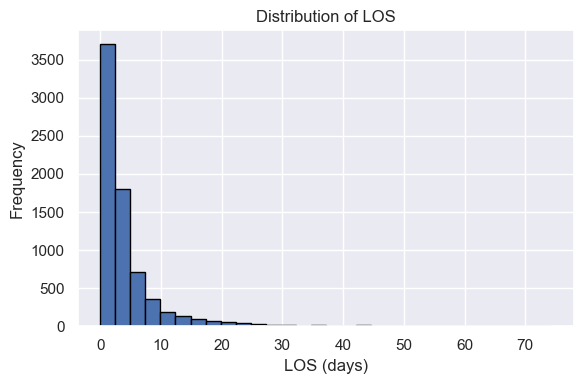


Patients with LOS above 20 days: 226 people
DataFrame after filtering LOS <= 20 days. New shape: (7058, 1030)


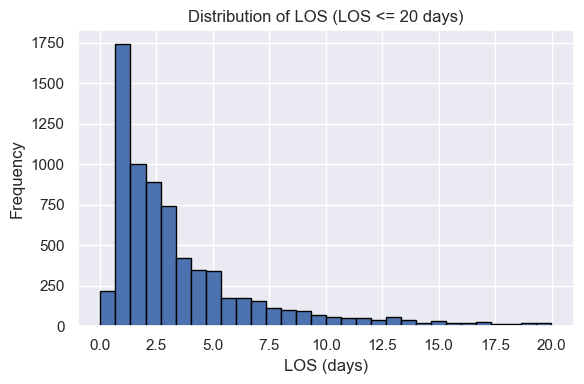

In [ ]:
# --- PART 11: Final Preparation for Modeling and Outlier/Missing Value Treatment ---
print("\n--- Part 11: Final Preparation for Modeling and Outlier/Missing Value Treatment ---")
if not df_final.empty:
    df_model_data = df_final.copy()
    df_model_data.set_index('ICUSTAY_ID', inplace=True)

    print("DataFrame for modeling (after renaming and setting index):")
    print(df_model_data.shape)
    print("First columns (sample):", list(df_model_data.columns[:5]))
    print("Last columns (sample):", list(df_model_data.columns[-5:]))

    missing_pct = df_model_data.isnull().mean() * 100
    print("\nPercentage of Missing Values per Column:")
    print(missing_pct.sort_values(ascending=False).round(2).head(10))

    plt.figure(figsize=(6, 4))
    plt.hist(df_model_data['LOS'].dropna(), bins=30, edgecolor='black')
    plt.xlabel('LOS (days)')
    plt.ylabel('Frequency')
    plt.title('Distribution of LOS')
    plt.tight_layout()
    plt.show()

    count_above_20 = (df_model_data['LOS'] >= 20).sum()
    print(f"\nPatients with LOS above 20 days: {count_above_20} people")

    df_clean = df_model_data[df_model_data['LOS'] <= 20].copy()
    print(f"DataFrame after filtering LOS <= 20 days. New shape: {df_clean.shape}")

    plt.figure(figsize=(6, 4))
    plt.hist(df_clean['LOS'], bins=30, edgecolor='black')
    plt.xlabel('LOS (days)')
    plt.ylabel('Frequency')
    plt.title('Distribution of LOS (LOS <= 20 days)')
    plt.tight_layout()
    plt.show()

In [ ]:
# --- PART 11: Handling Missing Values - Removing Empty Features ---
print("\n--- Part 11: Handling Missing Values - Removing Empty Features ---")

# We will work with df_clean which already has LOS filtered
df_prep = df_clean.copy()

# Calculate the percentage of missing values per column
missing_pct = df_prep.isnull().mean() * 100

threshold_missing = 90 # Minimum percentage of NaN to remove the column
cols_to_drop = missing_pct[missing_pct >= threshold_missing].index.tolist()

if 'LOS' in cols_to_drop: # Ensure the 'LOS' column is not accidentally removed
    cols_to_drop.remove('LOS')

print(f"Columns with more than {threshold_missing}% missing values that will be removed: {len(cols_to_drop)}")
# Remove the columns from the DataFrame
df_prep.drop(columns=cols_to_drop, inplace=True)
gc.collect() # Force garbage collection

print(f"DataFrame after removing columns with >{threshold_missing}% missing values. New shape: {df_prep.shape}")

# Display the new percentage of missing values in the remaining columns
remaining_missing_pct = df_prep.isnull().mean() * 100
print("\nPercentage of Missing Values in REMAINING Columns (Top 10):")
print(remaining_missing_pct.sort_values(ascending=False).round(2).head(10))

# Check if there are columns with 0% nulls now (besides LOS)
print(f"Number of columns with no missing values after this step: {(remaining_missing_pct == 0).sum()}")


--- Part 11: Handling Missing Values - Removing Empty Features ---
Columns with more than 90% missing values that will be removed: 895
DataFrame after removing columns with >90% missing values. New shape: (7058, 105)

Percentage of Missing Values in REMAINING Columns (Top 10):
Temperature Celsius                      89.91
Differential-Atyps                       89.80
Temporary Ventricular Stim Setting mA    89.32
Impaired Skin Width #1                   88.52
Temporary Ventricular Sens Setting mV    88.28
Impaired Skin Length #1                  88.07
Lipase                                   87.02
PA Line cm Mark                          86.71
Temporary Atrial Stim Threshold mA       86.57
Temporary Atrial Stim Setting mA         86.57
dtype: float64
Number of columns with no missing values after this step: 1


In [ ]:
# --- PART 11: Handling Missing Values - Imputation with KNNImputer ---
print("\n--- Part 11: Handling Missing Values - Imputation with KNNImputer ---")

# Separate features (X) from target (y) BEFORE imputation and scaling
# This is crucial to avoid imputing or scaling LOS
X = df_prep.drop(columns=['LOS']).copy()
y = df_prep['LOS'].copy()

print(f"Shape of X (features) before imputation: {X.shape}")
print(f"Shape of y (target LOS): {y.shape}")

imputer = KNNImputer(n_neighbors=5, weights='uniform')

print("Starting imputation with KNNImputer...")
# Apply imputation. KNNImputer returns a NumPy array.
X_imputed_array = imputer.fit_transform(X)

# Convert the imputed array back to a DataFrame, keeping column names and index
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns, index=X.index)
gc.collect() # Force garbage collection

print("Imputation completed.")

# Check if there are still missing values in X_imputed
missing_after_imputation = X_imputed.isnull().sum().sum()
print(f"Total missing values in X_imputed after imputation: {missing_after_imputation}")

print("\nStatistics of null values in X_imputed (should be zero):")
print(X_imputed.isnull().sum().sort_values(ascending=False).head())

# Recompose the DataFrame for visualization, but remember that for modeling X and y must be separate
df_prep_imputed = X_imputed.copy()
df_prep_imputed['LOS'] = y # Add the LOS column back

print(f"\nFinal DataFrame after imputation (df_prep_imputed). New shape: {df_prep_imputed.shape}")
print(df_prep_imputed.head())


--- Part 11: Handling Missing Values - Imputation with KNNImputer ---
Shape of X (features) before imputation: (7058, 104)
Shape of y (target LOS): (7058,)
Starting imputation with KNNImputer...
Imputation completed.
Total missing values in X_imputed after imputation: 0

Statistics of null values in X_imputed (should be zero):
Heart rate Alarm - High              0
Heart Rate Alarm - Low               0
Arterial Blood Pressure systolic     0
Arterial Blood Pressure diastolic    0
Arterial Blood Pressure mean         0
dtype: int64

Final DataFrame after imputation (df_prep_imputed). New shape: (7058, 105)
            Heart rate Alarm - High  Heart Rate Alarm - Low  \
ICUSTAY_ID                                                    
200001.0                      120.0                   60.00   
200021.0                      120.0                   50.00   
200024.0                      135.0                   50.00   
200040.0                      120.0                   60.00   
200059.0

# PART 12
This part splits the data into training and test sets, then applies correct scaling. First, the features (X) and target variable (y, which is LOS) are separated. The dataset is split so that 80% is for training and 20% for testing, keeping results reproducible with a fixed random seed. Next, a StandardScaler is fit only on the training data to learn the scaling parameters (mean and standard deviation). The training features are transformed accordingly. Then, the test features are scaled using the same parameters from the training set—crucially, without refitting the scaler—to avoid data leakage. The scaled data is converted back into DataFrames for convenience. Some basic checks on the scaled training data confirm the mean is close to zero and the standard deviation close to one, as expected. Finally, the scaled training and test sets, along with their corresponding targets, are saved to CSV files for use in model training and evaluation.
At some point we tried further feature selection but that reduced the models performance

In [ ]:
# --- PART 12: Train/Test Split and Correct Scaling ---
print("\n--- Part 12: Train/Test Split and Correct Scaling ---")


X = df_prep_imputed.drop(columns=['LOS']).copy()
y = df_prep_imputed['LOS'].copy()

print(f"Shape of X (features) before splitting: {X.shape}")
print(f"Shape of y (target LOS): {y.shape}")

# 1. Split the data into training and testing sets
# test_size=0.2 (20% for test), random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData split into training and testing:")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# 2. Initialize the StandardScaler
scaler = StandardScaler()

# 3. Fit the scaler ONLY on the TRAINING data and transform the TRAINING data
print("\nScaling X_train...")
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index) # Convert back to DataFrame
gc.collect()

# 4. Transform the TEST data using the ALREADY FITTED scaler (NO fit again)
print("Scaling X_test using the scaler fitted on X_train...")
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index) # Convert back to DataFrame
gc.collect()

print("Scaling completed for train and test.")

# Display the first few rows of the scaled DataFrame to confirm
print("\nSample of X_train_scaled (first 5 rows and 5 columns):")
print(X_train_scaled.iloc[:5, :5])

print("\nSample of X_test_scaled (first 5 rows and 5 columns):")
print(X_test_scaled.iloc[:5, :5])

# Check statistics to confirm training scaling (mean close to 0, standard deviation close to 1)
print("\nStatistics of some X_train_scaled columns (mean and standard deviation):")
print(X_train_scaled.iloc[:, :5].describe().loc[['mean', 'std']].round(2))



--- Part 12: Train/Test Split and Correct Scaling ---
Shape of X (features) before splitting: (7058, 104)
Shape of y (target LOS): (7058,)

Data split into training and testing:
Shape of X_train: (5646, 104)
Shape of X_test: (1412, 104)
Shape of y_train: (5646,)
Shape of y_test: (1412,)

Scaling X_train...
Scaling X_test using the scaler fitted on X_train...
Scaling completed for train and test.

Sample of X_train_scaled (first 5 rows and 5 columns):
            Heart rate Alarm - High  Heart Rate Alarm - Low  \
ICUSTAY_ID                                                    
213566.0                   0.359684               -0.018869   
241632.0                   0.415222               -0.039432   
246982.0                   0.359684               -0.039432   
284941.0                   1.525979               -0.016584   
251991.0                   1.240356               -0.026376   

            Arterial Blood Pressure systolic  \
ICUSTAY_ID                                     
213566

# PART 13
In this part, we train and evaluate several regression models to predict the target variable (LOS). We start by defining three models: Random Forest, Gradient Boosting, and Ridge Regression. For each model, we use 5-fold cross-validation on the training data to get a reliable estimate of performance across different metrics: mean absolute error (MAE), root mean squared error (RMSE), and R² score.

Because MAE and RMSE are reported as negative by default in cross_val_score, we invert their signs to make interpretation straightforward (lower MAE and RMSE are better).

After running cross-validation, we compare the average MAE across models to pick the best performing one. The model with the lowest mean MAE is selected as the best candidate.

Finally, we train the best model on the entire training set and evaluate it on the test set, reporting MAE, RMSE, and R² metrics to see how well it generalizes to unseen data.

In [ ]:
# --- PART 13: Training and Evaluation of Regression Models ---
print("\n--- Part 13: Training and Evaluation of Regression Models ---")

models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42, n_jobs=-1), # n_jobs=-1 uses all cores
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(random_state=42),
}

# Custom evaluation metrics for cross_val_score
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

results = {}

print("\nStarting model training and evaluation with cross-validation...")
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    cv_results = {}
    for metric_name, scorer in scoring.items():
        # cross_val_score returns an array of scores for each fold
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=scorer, n_jobs=-1)
        # Invert negative scores for MAE and RMSE
        if 'neg_' in scorer:
            scores = -scores
        cv_results[metric_name] = scores
        print(f"  {metric_name.upper()} (mean): {scores.mean():.4f} (+/- {scores.std():.4f})")

    results[name] = cv_results
    gc.collect() # Force garbage collection

print("\n--- Cross-Validation Results Summary ---")
for name, metrics in results.items():
    print(f"\nModel: {name}")
    for metric_name, scores in metrics.items():
        print(f"  {metric_name.upper()}: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")


best_model_name = None
best_mae = float('inf')

print("\nDetermining the best model based on mean MAE...")
for name, metrics in results.items():
    avg_mae = metrics['mae'].mean()
    if avg_mae < best_mae:
        best_mae = avg_mae
        best_model_name = name

print(f"\nBest model (with lowest mean MAE in cross-validation): {best_model_name}")
print(f"Mean MAE of the best model: {best_mae:.4f}")


print(f"\nTraining the final {best_model_name} on the full training set and evaluating on the test set...")
final_model = models[best_model_name]
final_model.fit(X_train_scaled, y_train)

y_pred_test = final_model.predict(X_test_scaled)

final_mae = mean_absolute_error(y_test, y_pred_test)
final_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
final_r2 = r2_score(y_test, y_pred_test)

print(f"\n--- Performance of {best_model_name} on the Final Test Set ---")
print(f"MAE on Test: {final_mae:.4f}")
print(f"RMSE on Test: {final_rmse:.4f}")
print(f"R2 on Test: {final_r2:.4f}")


--- Part 13: Training and Evaluation of Regression Models ---

Starting model training and evaluation with cross-validation...

--- Evaluating RandomForestRegressor ---
  MAE (mean): 2.1808 (+/- 0.0542)
  RMSE (mean): 3.1335 (+/- 0.1017)
  R2 (mean): 0.2105 (+/- 0.0185)

--- Evaluating GradientBoostingRegressor ---
  MAE (mean): 2.0968 (+/- 0.0431)
  RMSE (mean): 3.0831 (+/- 0.1016)
  R2 (mean): 0.2355 (+/- 0.0238)

--- Evaluating Ridge ---
  MAE (mean): 2.2703 (+/- 0.0553)
  RMSE (mean): 3.2722 (+/- 0.1273)
  R2 (mean): 0.1391 (+/- 0.0309)

--- Cross-Validation Results Summary ---

Model: RandomForestRegressor
  MAE: Mean = 2.1808, Std = 0.0542
  RMSE: Mean = 3.1335, Std = 0.1017
  R2: Mean = 0.2105, Std = 0.0185

Model: GradientBoostingRegressor
  MAE: Mean = 2.0968, Std = 0.0431
  RMSE: Mean = 3.0831, Std = 0.1016
  R2: Mean = 0.2355, Std = 0.0238

Model: Ridge
  MAE: Mean = 2.2703, Std = 0.0553
  RMSE: Mean = 3.2722, Std = 0.1273
  R2: Mean = 0.1391, Std = 0.0309

Determining the 

c:\Users\pedro\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Among them, Gradient Boosting showed the best performance with the lowest average MAE of 2.10, followed by Random Forest (2.18) and Ridge (2.27). It also had the best RMSE and R² scores.

The Gradient Boosting model was then trained on the full training set and tested on the unseen test set, achieving a MAE of 1.99, RMSE of 2.94, and an R² of 0.26, indicating reasonable predictive accuracy and generalization.

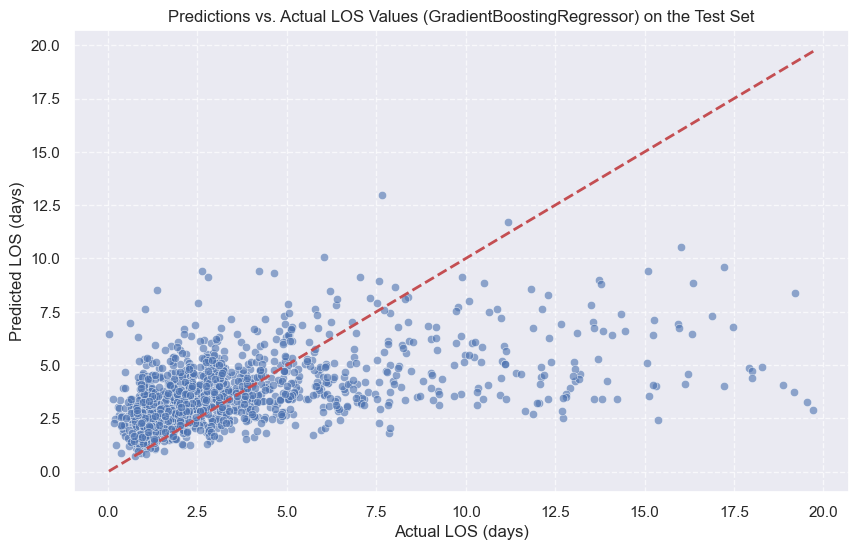

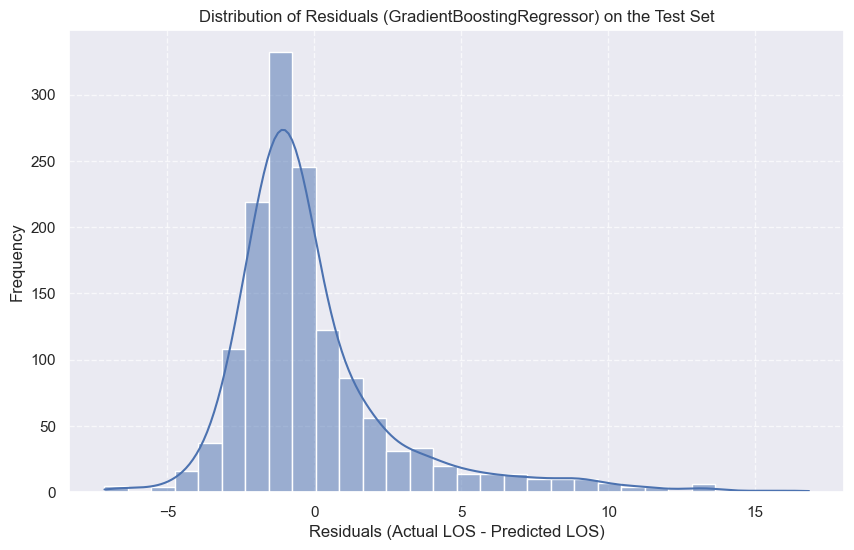

In [ ]:
#Plot predictions vs. actuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual LOS (days)")
plt.ylabel("Predicted LOS (days)")
plt.title(f"Predictions vs. Actual LOS Values ({best_model_name}) on the Test Set")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred_test, kde=True, bins=30)
plt.xlabel("Residuals (Actual LOS - Predicted LOS)")
plt.ylabel("Frequency")
plt.title(f"Distribution of Residuals ({best_model_name}) on the Test Set")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Despite this we can clearly see that the model doesn't generalize well for longer length of stays (LOS) having a hard time with those and focusing mostly on the initial higher frequency data.

# PART 14
We used GridSearchCV with 5-fold cross-validation to find the best hyperparameters for the GradientBoostingRegressor, optimizing for the lowest mean absolute error (MAE).

After testing combinations of trees, learning rates, depths, and sample splits, the best model was selected and evaluated on the test set, showing improved prediction accuracy.

Plots of predicted vs. actual values and residuals help visualize model performance and error distribution.


--- Part 14: Hyperparameter Optimization with GridSearchCV for GradientBoostingRegressor ---
Starting GridSearchCV for GradientBoostingRegressor...
Total number of parameter combinations to test: 108
Fitting 5 folds for each of 108 candidates, totalling 540 fits

GridSearchCV completed.

--- GridSearchCV Results ---
Best parameters found: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best mean cross-validation MAE: 2.0453

Evaluating the best GradientBoostingRegressor on the Final Test Set (with the best parameters):
MAE on Test (Optimized): 1.9599
RMSE on Test (Optimized): 2.9252
R2 on Test (Optimized): 0.2639


c:\Users\pedro\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


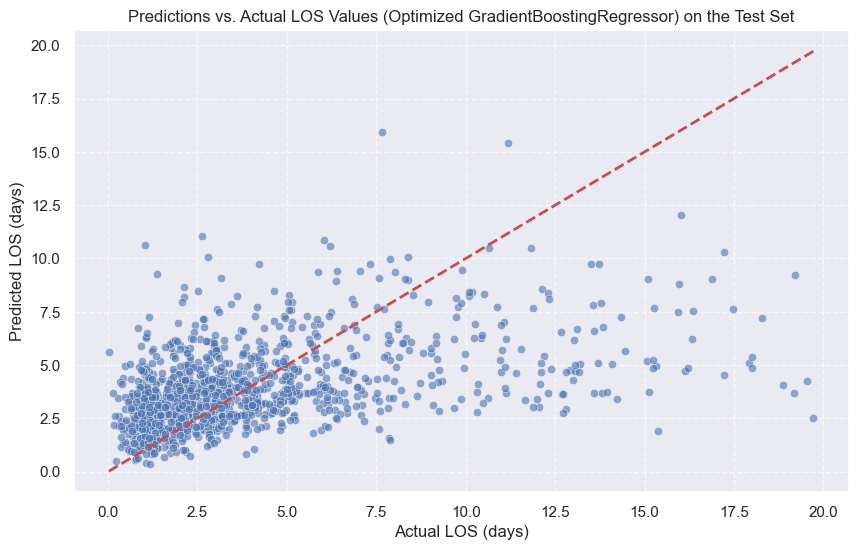

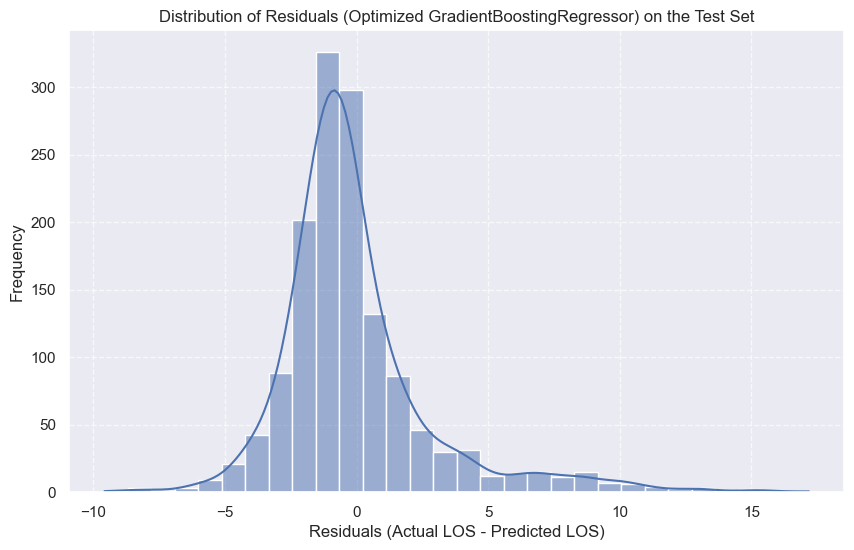

In [ ]:
# --- PART 14: Hyperparameter Optimization with GridSearchCV for GradientBoostingRegressor ---
print("\n--- Part 14: Hyperparameter Optimization with GridSearchCV for GradientBoostingRegressor ---")


# Define the base model
gbr = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300], # Number of trees
    'learning_rate': [0.05, 0.1, 0.15], # Learning rate
    'max_depth': [3, 4, 5], # Maximum depth of each tree
    'min_samples_split': [2, 5], # Minimum samples to split a node
    'min_samples_leaf': [1, 2] # Minimum samples in a leaf node
}

# Define the scoring metric. We will use 'neg_mean_absolute_error' for optimization,
# as we want the lowest MAE (GridSearch maximizes, so we use the negative).
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

print("Starting GridSearchCV for GradientBoostingRegressor...")
print(f"Total number of parameter combinations to test: {np.prod([len(v) for v in param_grid.values()])}")

# Set up GridSearchCV
# cv=5: 5-fold cross-validation
# n_jobs=-1: use all available cores to speed up
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring=scorer,
    cv=5, # Cross-validation within GridSearchCV
    verbose=2, # Show more progress details
    n_jobs=-1 # Use all CPU cores
)

# Execute the grid search on the training set
grid_search.fit(X_train_scaled, y_train)

print("\nGridSearchCV completed.")

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_ # Remember to invert the sign because 'neg_mean_absolute_error' was used

print("\n--- GridSearchCV Results ---")
print(f"Best parameters found: {best_params}")
print(f"Best mean cross-validation MAE: {best_score:.4f}")

# Store the best model
best_gbr_model = grid_search.best_estimator_

# Evaluate the best model on the final test set (ONLY ONCE!)
print(f"\nEvaluating the best GradientBoostingRegressor on the Final Test Set (with the best parameters):")
y_pred_best_gbr = best_gbr_model.predict(X_test_scaled)

final_mae_best_gbr = mean_absolute_error(y_test, y_pred_best_gbr)
final_rmse_best_gbr = mean_squared_error(y_test, y_pred_best_gbr, squared=False)
final_r2_best_gbr = r2_score(y_test, y_pred_best_gbr)

print(f"MAE on Test (Optimized): {final_mae_best_gbr:.4f}")
print(f"RMSE on Test (Optimized): {final_rmse_best_gbr:.4f}")
print(f"R2 on Test (Optimized): {final_r2_best_gbr:.4f}")

# Plot predictions vs. actuals for the optimized model
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best_gbr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual LOS (days)")
plt.ylabel("Predicted LOS (days)")
plt.title(f"Predictions vs. Actual LOS Values (Optimized GradientBoostingRegressor) on the Test Set")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#  Plot residuals for the optimized model
plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred_best_gbr, kde=True, bins=30)
plt.xlabel("Residuals (Actual LOS - Predicted LOS)")
plt.ylabel("Frequency")
plt.title(f"Distribution of Residuals (Optimized GradientBoostingRegressor) on the Test Set")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

While hyperparameter optimization yielded slight improvements in model performance, the underlying challenges in predicting Length of Stay persist. This indicates that the core limitations, possibly related to feature representation or the inherent complexity of LOS, were not fully resolved by tuning alone.

# PART 15
We performed a feature importance analysis using SHAP values on the best Gradient Boosting model. This method helps us understand how each feature influences the model’s predictions.

- We calculated SHAP values on a sample of the test data (up to 1000 samples) to keep computation manageable.
- We created a table ranking features by their average absolute SHAP values, showing which features contribute most to the model.
- We visualized global feature importance with summary bar and beeswarm plots, which display both the magnitude and direction of each feature's impact.
- We generated a dependence plot for the top feature, showing how changes in that feature affect predictions.
- Finally, we used a force plot to explain the prediction for a single test sample, highlighting how different features pushed the prediction higher or lower.

This analysis gives us valuable insights into the model's decision process and which features drive predictions most strongly.


--- Part 15: Feature Importance Analysis (With SHAP) ---


Calculating SHAP values for 1000 samples. This may take a while...
SHAP values calculated.

Feature importance DataFrame created:
                              Feature  Importance
0  Pulmonary Artery Pressure systolic    0.231479
1                            PEEP set    0.204916
2                   Resp Alarm - High    0.201850
3                       PH (dipstick)    0.187412
4                     PA Line cm Mark    0.178856

Visualizing Global Feature Importance (SHAP Summary Plot - Bar)...


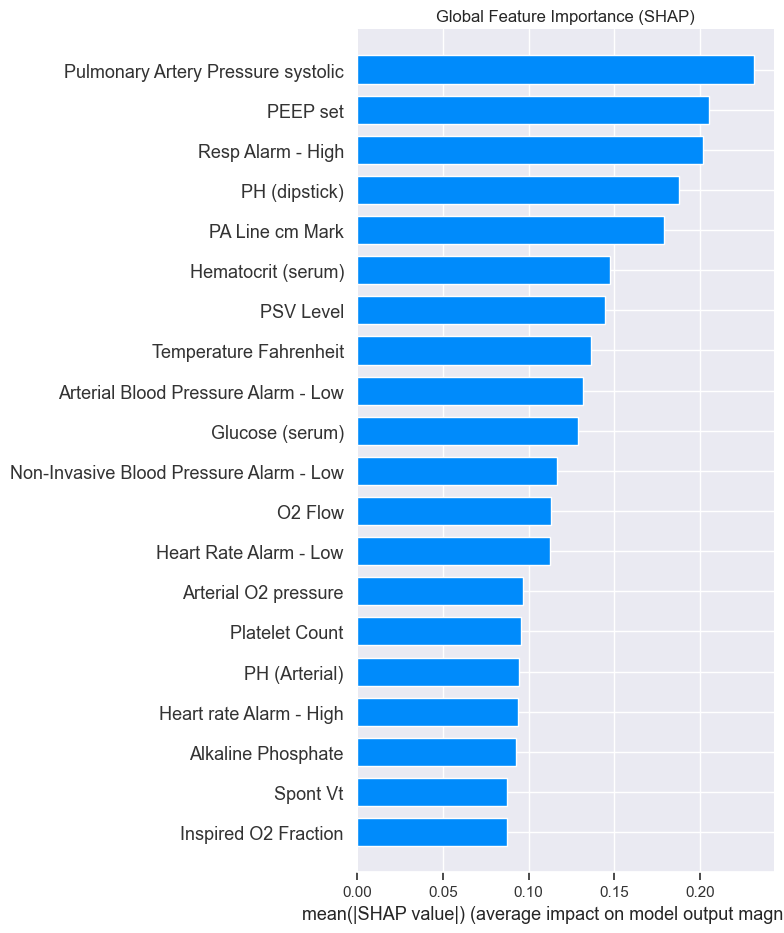

Visualizing Feature Impact and Distribution (SHAP Summary Plot - Beeswarm)...


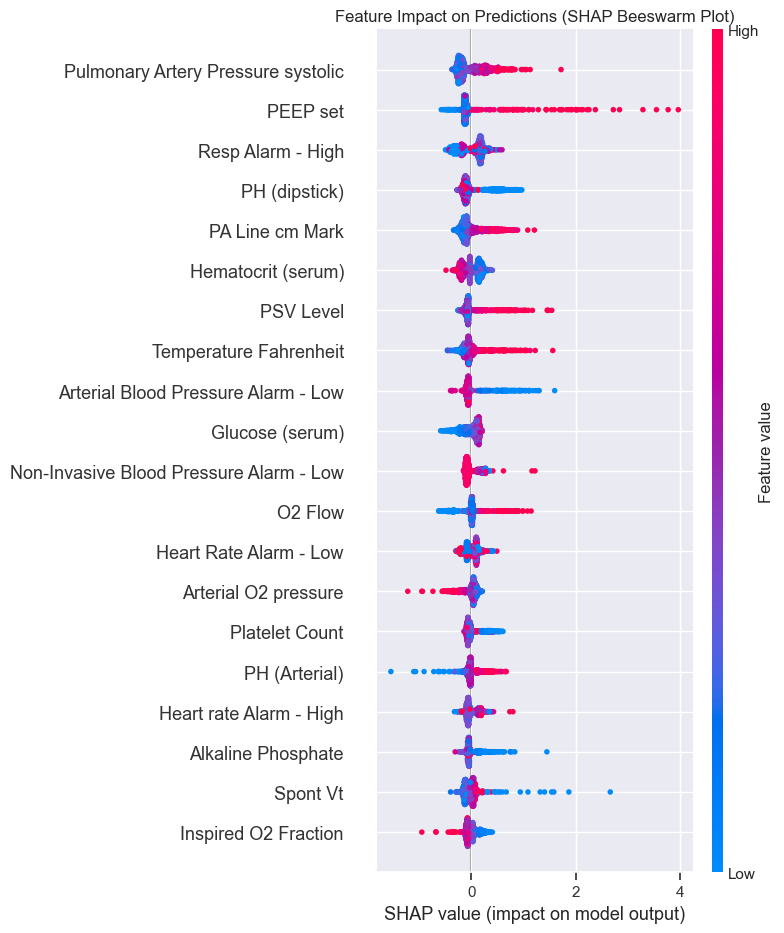


Visualizing the Impact of Feature 'Pulmonary Artery Pressure systolic' (SHAP Dependence Plot)...


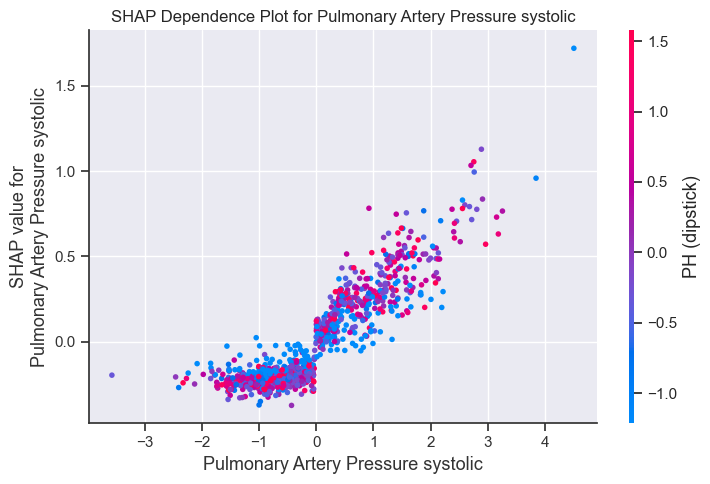


Explaining the individual prediction for test sample with index: 0
Actual LOS for this sample: 1.18
Predicted LOS for this sample: 0.38

SHAP analysis complete.


In [ ]:
# --- PART 15: Feature Importance Analysis (With SHAP) ---
print("\n--- Part 15: Feature Importance Analysis (With SHAP) ---")

# Ensure that best_gbr_model, X_train_scaled, X_test_scaled, y_test are available

# If 'best_gbr_model' is not in memory, you will need to reload/re-run Part 14
if 'best_gbr_model' not in locals():
    print("ERROR: 'best_gbr_model' not found in memory. Please execute Part 14 first.")
else:
    shap.initjs() # Enables JS visualization for interactive plots like force_plot

    # 2. Initialize the TreeExplainer for the GradientBoostingRegressor
    explainer = shap.TreeExplainer(best_gbr_model)

    # 3. Calculate SHAP values
    X_test_sample = X_test_scaled.sample(min(1000, len(X_test_scaled)), random_state=42) if len(X_test_scaled) > 1000 else X_test_scaled

    print(f"Calculating SHAP values for {len(X_test_sample)} samples. This may take a while...")
    shap_values = explainer.shap_values(X_test_sample)
    print("SHAP values calculated.")

    # **NEW: Create importance_df here, right after calculating shap_values**
    # Calculating the absolute mean importance of SHAP values for each feature
    feature_importance_abs_mean = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'Importance': feature_importance_abs_mean
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print("\nFeature importance DataFrame created:")
    print(importance_df.head())


    # 4. Visualize Global Feature Importance (SHAP Summary Plot - Bar)
    print("\nVisualizing Global Feature Importance (SHAP Summary Plot - Bar)...")
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title('Global Feature Importance (SHAP)')
    plt.tight_layout()
    plt.show()

    # Visualize Feature Impact and Distribution (SHAP Summary Plot - Beeswarm)
    print("Visualizing Feature Impact and Distribution (SHAP Summary Plot - Beeswarm)...")
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title('Feature Impact on Predictions (SHAP Beeswarm Plot)')
    plt.tight_layout()
    plt.show()

    # 5. Visualize Feature Dependence (Dependence Plot)
    # 'importance_df' should now be available
    top_feature_label = importance_df.iloc[0]['Feature'] # Get the top calculated feature

    # The check for 'top_feature_label' in X_test_sample.columns is still valid for safety
    if top_feature_label not in X_test_sample.columns:
        print(f"Warning: '{top_feature_label}' not found in DataFrame X_test_sample. Attempting to find an alternative.")
        if not X_test_sample.empty:
            top_feature_label = X_test_sample.columns[0]
            print(f"Using '{top_feature_label}' as fallback for Dependence Plot.")
        else:
            top_feature_label = None
            print("X_test_sample is empty. Skipping Dependence Plot.")

    if top_feature_label:
        print(f"\nVisualizing the Impact of Feature '{top_feature_label}' (SHAP Dependence Plot)...")
        shap.dependence_plot(top_feature_label, shap_values, X_test_sample, show=False)
        plt.title(f'SHAP Dependence Plot for {top_feature_label}')
        plt.tight_layout()
        plt.show()

    # 6. Explain an Individual Prediction (Force Plot)

    sample_index = 0
    if len(X_test_sample) > sample_index:
        print(f"\nExplaining the individual prediction for test sample with index: {sample_index}")
        print(f"Actual LOS for this sample: {y_test.loc[X_test_sample.index[sample_index]]:.2f}") # Use .loc
        print(f"Predicted LOS for this sample: {best_gbr_model.predict(X_test_sample.iloc[[sample_index]])[0]:.2f}")

        # Remove plt.show() after force_plot, as shap.force_plot() handles the display
        shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_sample.iloc[[sample_index]])
    else:
        print(f"\nNo sample at index {sample_index} in X_test_sample to generate the Force Plot.")

    print("\nSHAP analysis complete.")

Analysis of Model Performance and Feature Importance
This analysis provides a clear view into the inner workings of the Length of Stay (LOS) prediction model. While the SHAP (SHapley Additive exPlanations) plots effectively highlight the key features influencing the model's output, they also underscore a more significant issue: the model's substantial underperformance. The provided example, where an Actual LOS of 1.18 days was predicted as 0.38 days, reveals a critical discrepancy. This suggests that the model, in its current state, is not a reliable tool for forecasting patient LOS.

The analysis does, however, offer valuable insights into how the model arrives at its inaccurate conclusions.

Key Findings from SHAP Analysis:

Global Feature Importance (Bar Chart): The model identifies Pulmonary Artery Pressure systolic, PEEP set, and Resp Alarm - High as the most influential factors. This chart ranks features by their average impact on the magnitude of predictions, telling us which data points the model weighs most heavily overall.

Feature Impact on Individual Predictions (Beeswarm Plot): This plot offers a more nuanced view. Each dot represents a prediction for a single patient. It confirms that high values for features like Pulmonary Artery Pressure systolic (shown as red dots) tend to have a positive SHAP value, meaning they push the model to predict a longer length of stay. Conversely, lower values (blue dots) push the prediction lower. This helps us understand the direction of each feature's influence.

Dependence and Interaction (Dependence Plot): Focusing on the most important feature, Pulmonary Artery Pressure systolic, this plot visualizes its direct relationship with the predicted LOS. As systolic pressure increases, its SHAP value (and thus its contribution to the final prediction) also tends to increase. The coloration by a secondary feature, PH (dipstick), allows for the discovery of interaction effects, showing how the influence of one feature might be modulated by another.

**Conclusion:**

The SHAP analysis successfully makes the model's decision-making process transparent. We can clearly see which features are driving the predictions and in what direction. However, this transparency illuminates the model's core weakness. The features identified, while clinically relevant, are not being leveraged effectively to produce accurate LOS forecasts. This emphasizes the inherent difficulty of this prediction task with the current dataset and model architecture, pointing to a need for further feature engineering, exploration of more complex models, or the inclusion of additional data sources to close the significant gap between prediction and reality.

# Conclusions of the Model results
Despite extensive efforts to optimize feature selection and hyperparameters for the gradient boosting model, the results indicate that predicting Length of Stay (LOS) remains a challenging task with this approach. The model’s poor predictive performance suggests several important points:

Complexity and Variability of LOS:
LOS is inherently influenced by a complex interplay of clinical, demographic, and administrative factors that may not be fully captured or represented in the available dataset. The multifactorial nature and high variability of LOS across patients pose significant challenges for any predictive model.

Limitations of Features:
Even with optimized features, the dataset may lack key variables that have strong predictive power for LOS, such as detailed clinical trajectories, comorbidities, or nuanced care processes. Feature engineering alone might not overcome these limitations.

Data Quality and Granularity:
The accuracy and granularity of the input data (e.g., medication timings, interventions) could affect the model’s ability to detect patterns relevant to LOS. Missing data, measurement noise, or coding inconsistencies can degrade performance.

Modeling Approach Constraints:
Gradient boosting, although powerful, might be insufficient alone for modeling LOS, which could require more specialized approaches—such as time-to-event (survival) analysis, recurrent models capturing temporal dependencies, or multimodal data integration.

Implications for Clinical Use:
The poor predictive ability limits the model’s utility for clinical decision support related to LOS. It highlights the need for caution when interpreting model predictions and underscores the importance of complementary methods or data sources.